# Face Recognition -Model5
使用MTCNN進行人臉偵測

使用自建CNN模型進行人臉辨識

使用kaggle5位日本明星資料集

進行靜態圖像辨識

In [1]:
# 將警告訊息關掉
import warnings
warnings.filterwarnings('ignore')

#Utilities相關函式庫
import os
import sys

# 圖像處理函示庫
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

# 數值處理函式庫
import pandas as pd
import numpy as np

# 機器學習函式庫
from sklearn.model_selection import train_test_split

# 深度學習函式庫
import keras 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, concatenate,Input
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import RMSprop, Adam, SGD
from keras.utils import np_utils
from keras.models import Model,load_model
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

# 人臉偵測函式庫
from mtcnn import MTCNN
detector = MTCNN()

# 相關參數設定
picture_size = 224
batch_size = 8  # 一次用多少筆資料更新模型
num_classes = 5  # 資料集有幾個類別
epochs = 300      # 訓練迭代次數
save_dir = os.path.join(os.getcwd(), 'saved_models') # 儲存模型的路徑
model_name = 'Model5_InceptionV1_V1, trained_model.h5' # 模型名稱


Using TensorFlow backend.


In [2]:
# 直接讀取處理好的檔案
total_img_resized = np.load('total_crop_resized.npy')
labelnames = np.load('labelnames.npy')

In [3]:
# 切分訓練/測試資料
#train_x = total_img
#train_y = labelnames

train_x,test_x, train_y, test_y = train_test_split(total_img_resized,
                                                  labelnames,
                                                test_size = 0.1,stratify= labelnames)#random_state = 123,
print('train:',train_x.shape,'test:',test_x.shape)

# 正規化資料
# 標準化0~255的值到0~1
x_train_normalize = train_x.astype('float32') / 255.0
x_test_normalize = test_x.astype('float32') / 255.0

train: (403, 224, 224, 3) test: (45, 224, 224, 3)


In [8]:
# GoogLeNet-Inception-V1
#Define convolution with batchnromalization
def Conv2d_BN(x, nb_filter,kernel_size, padding='same',strides=(1,1),name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None

    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,activation='relu',name=conv_name)(x)
    x = BatchNormalization(axis=3,name=bn_name)(x)
    return x
  
#Define Inception structure
def Inception(x,nb_filter_para):
    (branch1,branch2,branch3,branch4)= nb_filter_para
    branch1x1 = Conv2D(branch1[0],(1,1), padding='same',strides=(1,1),name=None)(x)

    branch3x3 = Conv2D(branch2[0],(1,1), padding='same',strides=(1,1),name=None)(x)
    branch3x3 = Conv2D(branch2[1],(3,3), padding='same',strides=(1,1),name=None)(branch3x3)

    branch5x5 = Conv2D(branch3[0],(1,1), padding='same',strides=(1,1),name=None)(x)
    branch5x5 = Conv2D(branch3[1],(1,1), padding='same',strides=(1,1),name=None)(branch5x5)

    branchpool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x)
    branchpool = Conv2D(branch4[0],(1,1),padding='same',strides=(1,1),name=None)(branchpool)

    x = concatenate([branch1x1,branch3x3,branch5x5,branchpool],axis=3)

    return x
  
#Build InceptionV1 model
def InceptionV1(width, height, depth, classes):
    
    inpt = Input(shape=(width,height,depth))

    x = Conv2d_BN(inpt,64,(7,7),strides=(2,2),padding='same')
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
    x = Conv2d_BN(x,192,(3,3),strides=(1,1),padding='same')
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

    x = Inception(x,[(64,),(96,128),(16,32),(32,)]) #Inception 3a 28x28x256
    x = Inception(x,[(128,),(128,192),(32,96),(64,)]) #Inception 3b 28x28x480
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x) #14x14x480

    x = Inception(x,[(192,),(96,208),(16,48),(64,)]) #Inception 4a 14x14x512
    x = Inception(x,[(160,),(112,224),(24,64),(64,)]) #Inception 4a 14x14x512
    x = Inception(x,[(128,),(128,256),(24,64),(64,)]) #Inception 4a 14x14x512
    x = Inception(x,[(112,),(144,288),(32,64),(64,)]) #Inception 4a 14x14x528
    x = Inception(x,[(256,),(160,320),(32,128),(128,)]) #Inception 4a 14x14x832
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x) #7x7x832

    x = Inception(x,[(256,),(160,320),(32,128),(128,)]) #Inception 5a 7x7x832
    x = Inception(x,[(384,),(192,384),(48,128),(128,)]) #Inception 5b 7x7x1024

    #Using AveragePooling replace flatten
    x = AveragePooling2D(pool_size=(7,7),strides=(7,7),padding='same')(x)
    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(4098,activation='relu')(x)
    x = Dense(4098,activation='relu')(x)
    x = Dense(classes,activation='softmax')(x)
    
    model=Model(input=inpt,output=x)
    
    return model

model = InceptionV1(224,224,3,5)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 112, 112, 64) 9472        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 112, 112, 64) 256         conv2d_69[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 56, 56, 64)   0           batch_normalization_3[0][0]      
__________________________________________________________________________________________________
conv2d_70 

In [9]:
# 訓練模型
optimizer = Adam(lr=1e-6,decay=0.0001,beta_1=0.99,beta_2=0.999) #100e-6
model.compile(loss = 'categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])

In [10]:
# Data Augmentation
datagen  = ImageDataGenerator(
            rotation_range = 30,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            horizontal_flip = True, 
            vertical_flip = False,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode='nearest')

In [11]:
# Use ModelCheckpoint to save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, verbose = 1)

earlystop = EarlyStopping(monitor = 'val_loss', patience = 20, verbose = 1) # patience=10為連續10次模型loss沒再下降就停止

# Fit model
aug_ratio = 2
steps_per_epoch = int(aug_ratio * train_x.shape[0] / batch_size)
validation_steps = int(aug_ratio * test_x.shape[0] / batch_size)

model_history = model.fit_generator(datagen.flow(x_train_normalize, train_y, batch_size = batch_size),
                                   epochs = epochs,
                                   validation_data = (x_test_normalize, test_y),
                                   callbacks = [checkpoint, earlystop],
                                   steps_per_epoch=steps_per_epoch,
                                   validation_steps=validation_steps
                                   )

Epoch 1/300
100/100 [==============================] - 12s 123ms/step - loss: 1.9094 - acc: 0.2463 - val_loss: 1.5256 - val_acc: 0.4222

Epoch 00001: val_loss improved from inf to 1.52561, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model5_InceptionV1_V1, trained_model.h5
Epoch 2/300
100/100 [==============================] - 5s 54ms/step - loss: 1.6726 - acc: 0.3617 - val_loss: 1.5136 - val_acc: 0.3778

Epoch 00002: val_loss improved from 1.52561 to 1.51362, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model5_InceptionV1_V1, trained_model.h5
Epoch 3/300
100/100 [==============================] - 6s 59ms/step - loss: 1.5859 - acc: 0.3746 - val_loss: 1.3953 - val_acc: 0.4889

Epoch 00003: val_loss improved from 1.51362 to 1.39528, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model5_InceptionV1_V1, trained_model.h5
Epoch 4/300
100/100 [==============================] - 6s 59ms/step - loss: 1.585

100/100 [==============================] - 6s 59ms/step - loss: 1.1352 - acc: 0.5534 - val_loss: 1.0109 - val_acc: 0.6222

Epoch 00031: val_loss did not improve from 0.99987
Epoch 32/300
100/100 [==============================] - 6s 59ms/step - loss: 1.1332 - acc: 0.5629 - val_loss: 1.0077 - val_acc: 0.6667

Epoch 00032: val_loss did not improve from 0.99987
Epoch 33/300
100/100 [==============================] - 6s 60ms/step - loss: 1.0504 - acc: 0.5983 - val_loss: 1.0197 - val_acc: 0.5778

Epoch 00033: val_loss did not improve from 0.99987
Epoch 34/300
100/100 [==============================] - 6s 59ms/step - loss: 1.1365 - acc: 0.5513 - val_loss: 0.9962 - val_acc: 0.6222

Epoch 00034: val_loss improved from 0.99987 to 0.99618, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model5_InceptionV1_V1, trained_model.h5
Epoch 35/300
100/100 [==============================] - 6s 58ms/step - loss: 1.0848 - acc: 0.5900 - val_loss: 1.0250 - val_acc: 0.5556

Epoch 00

100/100 [==============================] - 6s 59ms/step - loss: 0.9357 - acc: 0.6541 - val_loss: 0.8859 - val_acc: 0.6667

Epoch 00063: val_loss did not improve from 0.88125
Epoch 64/300
100/100 [==============================] - 6s 59ms/step - loss: 0.9418 - acc: 0.6358 - val_loss: 0.8883 - val_acc: 0.6889

Epoch 00064: val_loss did not improve from 0.88125
Epoch 65/300
100/100 [==============================] - 6s 59ms/step - loss: 0.9396 - acc: 0.6441 - val_loss: 0.8858 - val_acc: 0.6889

Epoch 00065: val_loss did not improve from 0.88125
Epoch 66/300
100/100 [==============================] - 6s 59ms/step - loss: 0.9421 - acc: 0.6350 - val_loss: 0.8987 - val_acc: 0.6667

Epoch 00066: val_loss did not improve from 0.88125
Epoch 67/300
100/100 [==============================] - 6s 60ms/step - loss: 0.9203 - acc: 0.6391 - val_loss: 0.8903 - val_acc: 0.6889

Epoch 00067: val_loss did not improve from 0.88125
Epoch 68/300
100/100 [==============================] - 6s 60ms/step - loss: 0

100/100 [==============================] - 6s 59ms/step - loss: 0.8476 - acc: 0.6696 - val_loss: 0.8235 - val_acc: 0.7111

Epoch 00100: val_loss did not improve from 0.82201
Epoch 101/300
100/100 [==============================] - 6s 60ms/step - loss: 0.8333 - acc: 0.6980 - val_loss: 0.8412 - val_acc: 0.6889

Epoch 00101: val_loss did not improve from 0.82201
Epoch 102/300
100/100 [==============================] - 6s 61ms/step - loss: 0.8234 - acc: 0.6763 - val_loss: 0.8202 - val_acc: 0.7111

Epoch 00102: val_loss improved from 0.82201 to 0.82017, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model5_InceptionV1_V1, trained_model.h5
Epoch 103/300
100/100 [==============================] - 6s 59ms/step - loss: 0.8555 - acc: 0.6729 - val_loss: 0.8328 - val_acc: 0.6889

Epoch 00103: val_loss did not improve from 0.82017
Epoch 104/300
100/100 [==============================] - 6s 60ms/step - loss: 0.7912 - acc: 0.6992 - val_loss: 0.8138 - val_acc: 0.7111

Epoc

100/100 [==============================] - 6s 60ms/step - loss: 0.7290 - acc: 0.7221 - val_loss: 0.8182 - val_acc: 0.7111

Epoch 00140: val_loss did not improve from 0.79967
Epoch 141/300
100/100 [==============================] - 6s 60ms/step - loss: 0.7351 - acc: 0.7304 - val_loss: 0.7988 - val_acc: 0.7111

Epoch 00141: val_loss improved from 0.79967 to 0.79884, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model5_InceptionV1_V1, trained_model.h5
Epoch 142/300
100/100 [==============================] - 6s 59ms/step - loss: 0.7365 - acc: 0.7292 - val_loss: 0.7964 - val_acc: 0.7111

Epoch 00142: val_loss improved from 0.79884 to 0.79645, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model5_InceptionV1_V1, trained_model.h5
Epoch 143/300
100/100 [==============================] - 6s 59ms/step - loss: 0.7400 - acc: 0.7246 - val_loss: 0.7913 - val_acc: 0.7111

Epoch 00143: val_loss improved from 0.79645 to 0.79133, saving model to

In [26]:
# loading save model
print('Loading trained model')
model_path = os.path.join(save_dir, model_name)
model = load_model(model_path)

# Score trained model
scores = model.evaluate(x_test_normalize, test_y, verbose = 1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Loading trained model
45/45 [==============================] - 2s 34ms/step
Test loss: 0.9972473343213399
Test accuracy: 0.6222222288449605


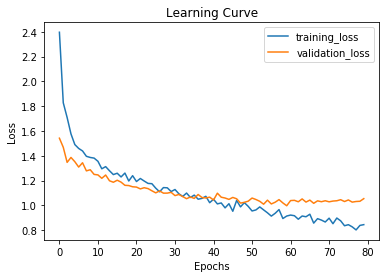

In [27]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()